In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [122]:
df = pd.read_csv("../data/Final_KasADockedTop1000_Master_JSFedit041423.csv")
df_other = pd.read_csv("../data/Scored KasADocked-RFModel.csv")

df_other.rename(
    {
        'score': 'Khadija PK RF Model Pred',
        'probability': 'Khadija PK RF Model Prob',
        'MoleculeId': 'Molecule Id'
    },
    axis=1,
    inplace=True
)

df = df[df['SMILES'].notna()]
assert df['SMILES'].is_unique

df.rename(
    {'Chemprop PK preds': 'Chemprop PK Prob', 'Chemprop PK preds.1': 'Chemprop PK Pred'}, 
    axis=1, 
    inplace=True
)


df.drop(['Khadija PK RF Model Pred'], axis=1, inplace=True)

df_other = df_other[df_other['Molecule Id'].notnull()][['Molecule Id', 'Khadija PK RF Model Pred', 'Khadija PK RF Model Prob']]

df = pd.merge(df, df_other, how='left', on='Molecule Id')

In [123]:
# Remove unnecessary columns
df.drop(['Unnamed: 0', 'Unnamed: 30', 'Composite Khadija PK Model Pred'], axis=1, inplace=True)

# Standardize column names with 'Pred' or 'Prob' as a suffix
replace_cols = {}

taacf_mlsmr_cols = [col for col in df.columns if 'TAACF' in col or 'MLSMR' in col or 'MLMSR' in col]

for col in taacf_mlsmr_cols:
    col_type = 'Prob' if 'Prob' in col else 'Pred'
    new_col = col.replace(col_type, '').strip() + ' ' + col_type
    new_col = new_col.replace('MLMSR', 'MLSMR')
    replace_cols[col] = new_col

cols = [col.replace('  ', ' ') for col in df.columns]
df.columns = cols
    
pk_p2_models = [
    'RandomForestClassifier/optuna/P2',
    'RandomForestClassifier/random_search/P2',
    'RandomForestClassifier/hyperopt/P2',
    'CatBoostClassifier/random_search/P2'
]

for col in pk_p2_models:
    replace_cols[col] = col + ' Prob'
    
df.rename(replace_cols, axis=1, inplace=True)

In [124]:
revised_thresh = {}
model_names = pk_p2_models

for col in model_names:
    q95 = df[col + ' Prob'].quantile(0.95)
    revised_thresh[col + ' Prob'] = q95
    
for col in model_names:
    df[col + ' Pred'] = df[col + ' Prob'].apply(lambda x: int(x >= revised_thresh[col + ' Prob']))

In [125]:
pred_cols = [col for col in df.columns if 'Pred' in col]
prob_cols = [col for col in df.columns if 'Prob' in col]

print(f"No. of models for which we have predictions = {len(pred_cols)}")
print(f"No. of models for which we have probabilities = {len(prob_cols)}")

No. of models for which we have predictions = 25
No. of models for which we have probabilities = 15


In [126]:
for col in [col for col in df.columns if 'Prob' in col]:
    new_col = col.replace('Prob', 'Rank')
    sorted_vals = sorted(dict(df[col]).items(), key=lambda x: -x[1])
    rank_dict = {sorted_vals[i][0]: i+1 for i in range(len(sorted_vals))}
    df[new_col] = [rank_dict[i] for i in range(len(df[col]))]
    
rank_cols = [col for col in df.columns if 'Rank' in col]

In [127]:
mic_cols = set([col for col in df.columns if 'TAACF' in col or 'MLSMR' in col])
pk_cols = set([col for col in df.columns if 'PK' in col or 'P2' in col])

pred_set = set(pred_cols)
prob_set = set(prob_cols)
rank_set = set(rank_cols)

In [128]:
class PredScore:
    def __init__(self, subset):
        self.subset = subset
    
    def calculate(self, row):
        score = 0
        for col in self.subset:
            score += row[col]

        return score
    

class PercentileScorer:
    def __init__(self, subset, top_perc=0.05):
        self.subset = subset
        self.top_perc = top_perc

    def top_5_percentile_score(self, row):
        top_5_p_score = 0
        for col in self.subset:
            if row[col] <= int(df.shape[0]*self.top_perc):
                top_5_p_score += 1
        return top_5_p_score


class CumulativeRanker:
    def __init__(self, subset):
        self.subset = subset

    def neg_rank(self, row):
        cum_rank = 0
        for col in self.subset:
            cum_rank += row[col]
        return -cum_rank

Pred Scores

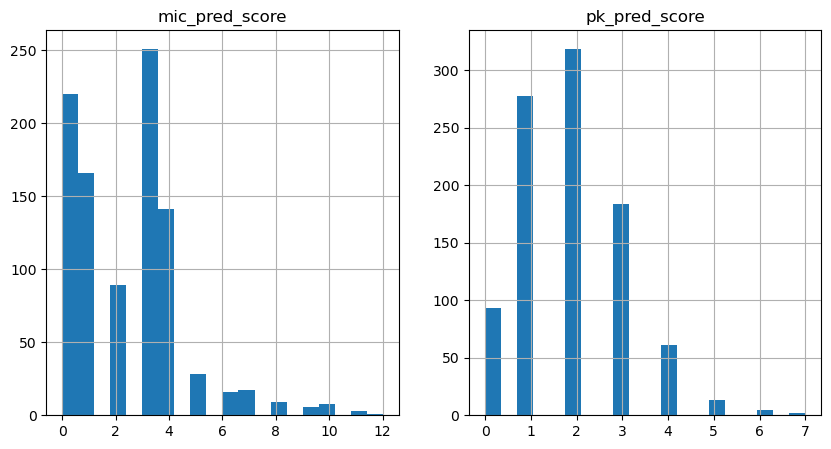

In [129]:
mic_pred_scorer = PredScore(mic_cols&pred_set)
pk_pred_scorer = PredScore(pk_cols&pred_set)

df['mic_pred_score'] = df.apply(mic_pred_scorer.calculate, axis=1)
df['pk_pred_score'] = df.apply(pk_pred_scorer.calculate, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df['mic_pred_score'].hist(bins=20, ax=axes[0])
df['pk_pred_score'].hist(bins=20, ax=axes[1])

axes[0].set_title('mic_pred_score')
axes[1].set_title('pk_pred_score')

plt.show()

Percentile Scores

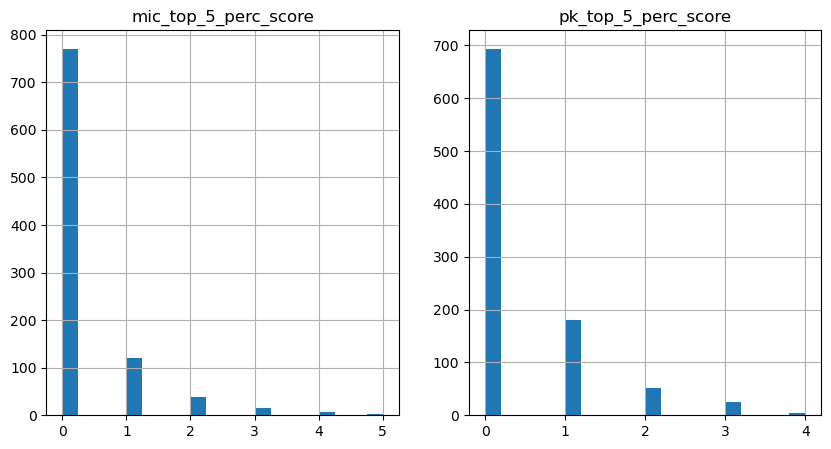

In [130]:
mic_perc_scorer = PercentileScorer(mic_cols&rank_set)
pk_perc_scorer = PercentileScorer(pk_cols&rank_set)

df['mic_top_5_perc_score'] = df.apply(mic_perc_scorer.top_5_percentile_score, axis=1)
df['pk_top_5_perc_score'] = df.apply(pk_perc_scorer.top_5_percentile_score, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df['mic_top_5_perc_score'].hist(bins=20, ax=axes[0])
df['pk_top_5_perc_score'].hist(bins=20, ax=axes[1])

axes[0].set_title('mic_top_5_perc_score')
axes[1].set_title('pk_top_5_perc_score')

plt.show()

Negative Cumulative Rank

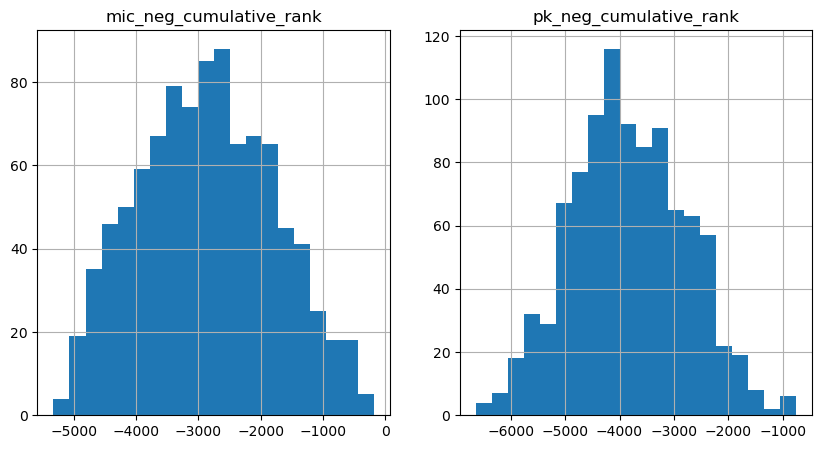

In [131]:
mic_cum_ranker = CumulativeRanker(mic_cols&rank_set)
pk_cum_ranker = CumulativeRanker(pk_cols&rank_set)

df['mic_neg_cumulative_rank'] = df.apply(mic_cum_ranker.neg_rank, axis=1)
df['pk_neg_cumulative_rank'] = df.apply(pk_cum_ranker.neg_rank, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df['mic_neg_cumulative_rank'].hist(bins=20, ax=axes[0])
df['pk_neg_cumulative_rank'].hist(bins=20, ax=axes[1])

axes[0].set_title('mic_neg_cumulative_rank')
axes[1].set_title('pk_neg_cumulative_rank')

plt.show()

In [132]:
pred_scorer = PredScore(pred_set)
perc_scorer = PercentileScorer(rank_set)
cum_ranker = CumulativeRanker(rank_set)

df['pred_score'] = df.apply(pred_scorer.calculate, axis=1)
df['top_5_perc_score'] = df.apply(perc_scorer.top_5_percentile_score, axis=1)
df['neg_cumulative_rank'] = df.apply(cum_ranker.neg_rank, axis=1)

### Heuristics

In [133]:
# Any compounds picked to be active across all MIC and PK model predictions
df[df['pred_score'] == len(pred_set)].shape[0]

0

In [134]:
# Up to 10 compounds with highest prediction score across all MIC models
highest_mic_pred_score = set(df.loc[df['mic_pred_score'].sort_values(ascending=False).index, 'SMILES'].head(10))
highest_mic_pred_score

{'C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(OCC2)cc1',
 'C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(cc1)cccc2',
 'Clc1c(Nc2nc3c(c(-c4ccc(Cl)cc4)c2)cccc3)cccc1',
 'Clc1cc(Nc2nc3c(c(-c4ccccc4)c2)cc(Cl)cc3)c(C(=O)c2ccccc2)cc1',
 'Clc1cc(Nc2nc3c(c(-c4ccccc4)c2)ccc(Cl)c3)c(C(=O)c2ccccc2)cc1',
 'Clc1cc2nccc(N3CCN(C(=O)CCc4oc(-c5ccccc5)cc4)CC3)c2cc1',
 'Fc1c(N2CCN(Cc3c(c(N)n(-c4ccc(F)cc4)n3)-c3ccccc3)CC2)cccc1',
 'Fc1c(NC(=O)COC(=O)c2c3c(nc4c2CN(Cc2ccccc2)CC4)cccc3)c(F)ccc1',
 'N(Nc1nc(-c2ccccc2)c2c(n1)cc(C)cc2)=Cc1c2c([nH]c1)cccc2',
 'O=C(N1CCN(Cc2sc3c(n2)cccc3)CC1)c1c2c(nc(-c3ccc(C)cc3)c1)cccc2'}

In [135]:
# Up to 30 compounds with highest neg cumulative rank across all models
highest_neg_cum_rank = set(df.loc[df['neg_cumulative_rank'].sort_values(ascending=False).index, 'SMILES'].head(31))
highest_neg_cum_rank

{'BrC1=CN2C(=NC(=NC(=O)c3sc4n(-c5ccccc5)nc(C)c4c3)c3c(cccc3)C2)C=C1',
 'Brc1cc(C2=NN(c3nc(-c4ccc(C)cc4)c4c(n3)cccc4)C(c3cc(Br)ccc3)C2)ccc1',
 'Brc1cc2c(C(=O)Nc3scc(-c4ncccc4)n3)cc(-c3ccccc3)nc2cc1',
 'Brc1cc2c(c(c(Cl)nc2cc1)-c1nc2c(c(-c3ccccc3)c1)ccc(Cl)c2)-c1ccccc1',
 'C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(OCC2)cc1',
 'C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(cc1)cccc2',
 'Clc1c(Nc2nc3c(c(-c4ccc(Cl)cc4)c2)cccc3)cccc1',
 'Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(OC)ccc4)=N3)nc2cc1',
 'Clc1ccc(-c2nc(N3C(c4cc(C)ccc4)CC(c4ccc(N(C)C)cc4)=N3)nc3c2cccc3)cc1',
 'Clc1ccc(-c2nc(NN=Cc3nc4c(cc3)cccc4)nc3c2cccc3)cc1',
 'FC(F)(F)c1cc(-c2nc(NC(=O)C3CCN(C(=O)c4ccc(F)cc4)CC3)sc2)ccc1',
 'FC(F)(F)c1cc(NC(=O)COC(=O)c2c3c(nc(-c4c5c(ccc4)cccc5)c2)cccc3)c(N2CCOCC2)cc1',
 'FC(F)(F)c1cc(NC=C2C(=O)N(c3cc(C(F)(F)F)ccc3)C(=O)c3c2cccc3)ccc1',
 'FC(F)(F)c1ccc(-c2c(C(=O)Nc3c(OC)cc4c(oc5c4cccc5)c3)cccc2)cc1',
 'Fc1c(C2Oc3c(cccc3)C3N2N=C(c2ccc(-c4ccccc4)cc2)C3)cccc1',
 'Fc1c(N2CCN(Cc3c(c(N)n(-c4ccc(F

In [136]:
# Up to 10 compounds with highest cumulative prediction score across all MIC models
highest_pred_score = set(df.loc[df['pred_score'].sort_values(ascending=False).index, 'SMILES'].head(31))
highest_pred_score

{'Brc1cc(C2N(c3nc(-c4ccccc4)c4c(n3)ccc(Cl)c4)N=C(c3ccccc3)C2)ccc1',
 'Brc1cc2c(C(=O)Nc3scc(-c4ncccc4)n3)cc(-c3ccccc3)nc2cc1',
 'Brc1cc2c(c(c(Cl)nc2cc1)-c1nc2c(c(-c3ccccc3)c1)ccc(Cl)c2)-c1ccccc1',
 'C(N1CCN(C=2n3nc(-c4cnccc4)nc3-c3c(N=2)cccc3)CC1)(c1ccccc1)c1ccccc1',
 'C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(OCC2)cc1',
 'C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(cc1)cccc2',
 'Clc1c(-c2nc3c(c(C(=O)C4=C5SC=C(c6ccccc6)N5CCCC4)c2)cccc3)cccc1',
 'Clc1c(Nc2nc3c(c(-c4ccc(Cl)cc4)c2)cccc3)cccc1',
 'Clc1cc(Nc2nc3c(c(-c4ccccc4)c2)cc(Cl)cc3)c(C(=O)c2ccccc2)cc1',
 'Clc1cc(Nc2nc3c(c(-c4ccccc4)c2)ccc(Cl)c3)c(C(=O)c2ccccc2)cc1',
 'Clc1cc2nc(O)c(c(-c3ccccc3)c2cc1)-c1nc2c(c(-c3ccccc3)c1)ccc(Cl)c2',
 'Clc1cc2nccc(N3CCN(C(=O)CCc4oc(-c5ccccc5)cc4)CC3)c2cc1',
 'Clc1ccc(-c2nc(N3C(c4cc(C)ccc4)CC(c4ccc(N(C)C)cc4)=N3)nc3c2cccc3)cc1',
 'Clc1ccc(-c2nc(NN=Cc3nc4c(cc3)cccc4)nc3c2cccc3)cc1',
 'Clc1ccc(-c2nc3c(c(C(=O)Nc4n(-c5ncccc5)nc(C)c4)c2)cccc3)cc1',
 'FC(F)(F)c1ccc(-c2c(C(=O)Nc3c(OC)cc4c(oc5c4cccc5)c3)ccc

In [137]:
df['highest_pred_score'] = df['SMILES'].apply(lambda x: x in highest_pred_score)
df['highest_neg_cum_rank'] = df['SMILES'].apply(lambda x: x in highest_neg_cum_rank)
df['highest_mic_pred_score'] = df['SMILES'].apply(lambda x: x in highest_mic_pred_score)

def select(row):
    return row['highest_pred_score'] or \
           row['highest_neg_cum_rank'] or \
           row['highest_mic_pred_score']

df['select'] = df.apply(select, axis=1)

df_select = df[df['select']] 
print(f"Selected {df_select.shape[0]} molecules.")

Selected 47 molecules.


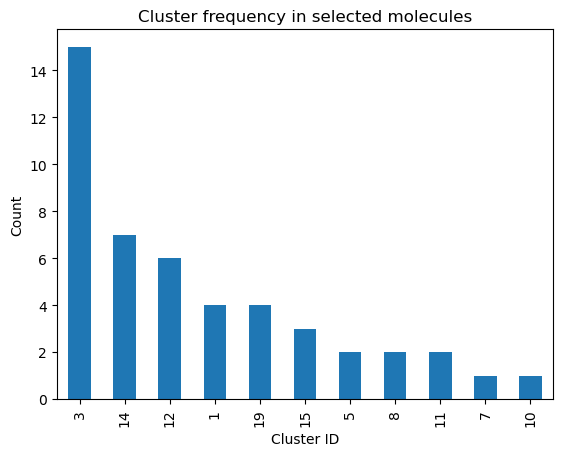

In [138]:
fig, ax = plt.subplots()
df_select['Cluster'].value_counts().plot(ax=ax, kind='bar')
ax.set_title('Cluster frequency in selected molecules')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Count')
plt.show()

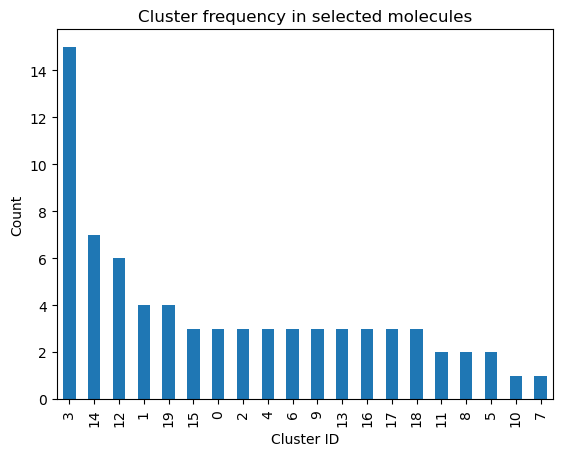

In [139]:
all_clusters = set(df['Cluster'])
unused_clusters = set(df_select['Cluster'])
missing_clusters = all_clusters - unused_clusters
df_missing_clusters = df[df['Cluster'].isin(missing_clusters)]

choose_idxs = list([x[1] for x in df_missing_clusters.groupby('Cluster')['neg_cumulative_rank'].nlargest(3).index])
df_select_add = pd.concat([df_select, df.loc[choose_idxs]])

df_select_add['diversity_selection'] = [False]*df_select.shape[0] + [True]*len(choose_idxs)
df_select_add.drop(['select'], axis=1, inplace=True)

fig, ax = plt.subplots()
df_select_add['Cluster'].value_counts().plot(ax=ax, kind='bar')
ax.set_title('Cluster frequency in selected molecules')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Count')
plt.show()

In [140]:
df_select_add

,Molecule Index,Molecule Id,SMILES,molStripped,Cluster,TAACF MIC Classic RF F1 Prob,TAACF MIC Classic RF F1 _NoTH Pred,TAACF MIC Classic RF F1 _J TH Pred,TAACF MIC Classic RF F1 _F1 TH Pred,TAACF MIC Class Weight F1 Prob,...,pk_top_5_perc_score,mic_neg_cumulative_rank,pk_neg_cumulative_rank,pred_score,top_5_perc_score,neg_cumulative_rank,highest_pred_score,highest_neg_cum_rank,highest_mic_pred_score,diversity_selection
20,20,Z318114792,FC(F)(F)c1cc(-c2nc(NC(=O)C3CCN(C(=O)c4ccc(F)cc...,FC(F)(F)c1cc(-c2nc(NC(=O)C3CCN(C(=O)c4ccc(F)cc...,1,0.017923,0,0,0,0.371184,...,3,-1879,-769,10,3,-3187,False,True,False,False
22,22,Z56688850,BrC1=CN2C(=NC(=NC(=O)c3sc4n(-c5ccccc5)nc(C)c4c...,BrC1=CN2C(=NC(=NC(=O)c3sc4n(-c5ccccc5)nc(C)c4c...,1,0.254134,0,0,0,0.176196,...,0,-1097,-2380,8,3,-3491,False,True,False,False
31,31,Z27663993,O=C(Nc1ccc(-c2sc3c(n2)ccc(C)c3)cc1)c1n(-c2cccc...,O=C(Nc1ccc(-c2sc3c(n2)ccc(C)c3)cc1)c1n(-c2cccc...,1,0.035117,0,0,0,0.310438,...,3,-1347,-2470,10,3,-3869,True,False,False,False
49,49,Z28887309,O=C(N1CCN(Cc2ccc(C#N)cc2)CC1)c1n(-c2ccccc2)nc(...,O=C(N1CCN(Cc2ccc(C#N)cc2)CC1)c1n(-c2ccccc2)nc(...,1,0.246433,0,0,0,0.242724,...,3,-1444,-1384,9,4,-2886,False,True,False,False
83,83,Z1157836627,C(N1CCN(C=2n3nc(-c4cnccc4)nc3-c3c(N=2)cccc3)CC...,C(N1CCN(C=2n3nc(-c4cnccc4)nc3-c3c(N=2)cccc3)CC...,3,0.048798,0,0,0,0.615068,...,1,-404,-3980,10,3,-4446,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,908,Z212593638,Clc1ccc(CN2CCN(C(=O)C3=NN(c4ccccc4)C(=O)c4c3cc...,Clc1ccc(CN2CCN(C(=O)C3=NN(c4ccccc4)C(=O)c4c3cc...,17,0.082426,0,0,0,0.149820,...,0,-1549,-4029,7,2,-5602,False,False,False,True
885,886,Z82203216,O=C(Nc1ccc(-n2c3c(nc2)cccc3)cc1)C1=NN(c2ccccc2...,O=C(Nc1ccc(-n2c3c(nc2)cccc3)cc1)C1=NN(c2ccccc2...,17,0.023271,0,0,0,0.149346,...,0,-2588,-2653,5,0,-5617,False,False,False,True
916,917,Z14474580,O=C(NC(c1ccccc1)c1ccccc1)CN1C(=O)C(c2ccccc2)(c...,O=C(NC(c1ccccc1)c1ccccc1)CN1C(=O)C(c2ccccc2)(c...,18,0.017728,0,0,0,0.254176,...,0,-4059,-2479,3,0,-7126,False,False,False,True
922,923,Z14471296,Fc1ccc(NC(=O)C(N2C(=O)C(c3ccccc3)(c3ccccc3)NC2...,Fc1ccc(NC(=O)C(N2C(=O)C(c3ccccc3)(c3ccccc3)NC2...,18,0.020569,0,0,0,0.191341,...,3,-3824,-3118,7,3,-7319,False,False,False,True


In [26]:
df_select_add = pd.read_csv('../data/selected_mols_apr30.csv')

In [27]:
df_select_add

,Unnamed: 0,Molecule Index,Molecule Id,SMILES,molStripped,Cluster,TAACF MIC Classic RF F1 Prob,TAACF MIC Classic RF F1 _NoTH Pred,TAACF MIC Classic RF F1 _J TH Pred,TAACF MIC Classic RF F1 _F1 TH Pred,...,pk_top_5_perc_score,mic_neg_cumulative_rank,pk_neg_cumulative_rank,pred_score,top_5_perc_score,neg_cumulative_rank,highest_pred_score,highest_neg_cum_rank,highest_mic_pred_score,diversity_selection
0,20,20,Z318114792,FC(F)(F)c1cc(-c2nc(NC(=O)C3CCN(C(=O)c4ccc(F)cc...,FC(F)(F)c1cc(-c2nc(NC(=O)C3CCN(C(=O)c4ccc(F)cc...,1,0.017923,0,0,0,...,3,-1879,-769,10,3,-3187,False,True,False,False
1,22,22,Z56688850,BrC1=CN2C(=NC(=NC(=O)c3sc4n(-c5ccccc5)nc(C)c4c...,BrC1=CN2C(=NC(=NC(=O)c3sc4n(-c5ccccc5)nc(C)c4c...,1,0.254134,0,0,0,...,0,-1097,-2380,8,3,-3491,False,True,False,False
2,49,49,Z28887309,O=C(N1CCN(Cc2ccc(C#N)cc2)CC1)c1n(-c2ccccc2)nc(...,O=C(N1CCN(Cc2ccc(C#N)cc2)CC1)c1n(-c2ccccc2)nc(...,1,0.246433,0,0,0,...,3,-1444,-1384,9,4,-2886,False,True,False,False
3,83,83,Z1157836627,C(N1CCN(C=2n3nc(-c4cnccc4)nc3-c3c(N=2)cccc3)CC...,C(N1CCN(C=2n3nc(-c4cnccc4)nc3-c3c(N=2)cccc3)CC...,3,0.048798,0,0,0,...,1,-404,-3980,10,3,-4446,True,False,False,False
4,84,84,Z1386458621,Clc1cc(Nc2nc3c(c(-c4ccccc4)c2)ccc(Cl)c3)c(C(=O...,Clc1cc(Nc2nc3c(c(-c4ccccc4)c2)ccc(Cl)c3)c(C(=O...,3,0.026685,0,0,0,...,0,-816,-4526,12,4,-5350,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,907,908,Z212593638,Clc1ccc(CN2CCN(C(=O)C3=NN(c4ccccc4)C(=O)c4c3cc...,Clc1ccc(CN2CCN(C(=O)C3=NN(c4ccccc4)C(=O)c4c3cc...,17,0.082426,0,0,0,...,0,-1549,-4029,7,2,-5602,False,False,False,True
69,885,886,Z82203216,O=C(Nc1ccc(-n2c3c(nc2)cccc3)cc1)C1=NN(c2ccccc2...,O=C(Nc1ccc(-n2c3c(nc2)cccc3)cc1)C1=NN(c2ccccc2...,17,0.023271,0,0,0,...,0,-2588,-2653,5,0,-5617,False,False,False,True
70,916,917,Z14474580,O=C(NC(c1ccccc1)c1ccccc1)CN1C(=O)C(c2ccccc2)(c...,O=C(NC(c1ccccc1)c1ccccc1)CN1C(=O)C(c2ccccc2)(c...,18,0.017728,0,0,0,...,0,-4059,-2479,3,0,-7126,False,False,False,True
71,922,923,Z14471296,Fc1ccc(NC(=O)C(N2C(=O)C(c3ccccc3)(c3ccccc3)NC2...,Fc1ccc(NC(=O)C(N2C(=O)C(c3ccccc3)(c3ccccc3)NC2...,18,0.020569,0,0,0,...,3,-3824,-3118,7,3,-7319,False,False,False,True


### Analysis of Observed Data

In [56]:
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt

df_res = pd.read_csv('../data/PK_MIC_40_Cmpds.csv')
df_res = pd.merge(df_res, df, left_on='enamine_id', right_on='Molecule Id', how='left')

df_res['mol_wt_(g/mol)'] = df_res['SMILES'].apply(lambda x: ExactMolWt(Chem.MolFromSmiles(x)))
df_res['mic_(µg/ml)'] = df_res['mtb_mic_(µm)']*df_res['mol_wt_(g/mol)']/1000
df_res = df_res[['enamine_id', 'SMILES', 'mtb_mic_(µm)', 'mic_(µg/ml)', 'mtb_mic_(µg/ml)', 'snapshot_pk_auc_(h*ng/ml)', 'pk_active', 'mic_active']]

df_res['mic_active_conservative'] = df_res['mtb_mic_(µm)'].apply(lambda x: 1 if x <= 10 else 0)
df_res['mic_active_generous'] = df_res.apply(lambda row: 1 if (row['mtb_mic_(µm)'] <= 10 or row['mic_(µg/ml)'] <= 10) else 0, axis=1)
df_res.drop(['mic_active', 'mtb_mic_(µg/ml)'], axis=1, inplace=True)
df_res.rename({'mtb_mic_(µm)': 'min_mic_(µm)', 'mic_(µg/ml)': 'min_mic_(µg/ml)', 'SMILES': 'structure'}, axis=1, inplace=True)
df_res['pk_active'] = df_res.apply(lambda row: row['pk_active'] if pd.notnull(row['snapshot_pk_auc_(h*ng/ml)']) else np.nan, axis=1)

df_res.to_csv('../data/processed_pk_mic_40_cmpds.csv')

/tmp/ipykernel_104309/3847096192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['mic_active_conservative'] = df_res['mtb_mic_(µm)'].apply(lambda x: 1 if x <= 10 else 0)


In [118]:
df_res

,enamine_id,structure,min_mic_(µm),min_mic_(µg/ml),snapshot_pk_auc_(h*ng/ml),pk_active,mic_active_conservative,mic_active_generous
0,Z137249014,Fc1c(-c2oc(C(=O)NN3C(=O)C(c4ccccc4)(c4ccccc4)N...,100.00,45.512813,37105.0,1.0,0,0
1,Z99494278,O=C(N1CCC(C(=O)Nc2cc3OCOc3cc2)CC1)C1=NN(c2cccc...,100.00,49.617467,18025.0,1.0,0,0
2,Z82203216,O=C(Nc1ccc(-n2c3c(nc2)cccc3)cc1)C1=NN(c2ccccc2...,100.00,45.715387,445.0,0.0,0,0
3,Z285125220,Clc1cc2nccc(N3CCN(C(=O)CCc4oc(-c5ccccc5)cc4)CC...,100.00,44.515570,402.0,0.0,0,0
4,Z140090268,O=C(CCC1=Nc2n(-c3ccccc3)ncc2C(=O)N1)N1C(c2cc3O...,100.00,48.520630,116.0,0.0,0,0
5,Z102669950,O=C(N1CCN(Cc2cc3c(OCC3)cc2)CC1)c1cc2c(-c3ccccc...,100.00,43.918959,30.0,0.0,0,0
6,Z128095220,C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(O...,25.00,10.580148,2911.0,1.0,0,0
7,Z105382408,Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...,100.00,49.217954,23.0,0.0,0,0
8,Z102666506,O=C(N1CCN(Cc2cc3c(OCC3)cc2)CC1)C1=NN(Cc2ccccc2...,100.00,48.021614,105.0,0.0,0,0
9,Z237483836,C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(c...,100.00,43.121100,2650.0,1.0,0,0


In [104]:
# Settings for plots

MIC_PRED_MODE = 'generous'
MIC_UNIT_PLTS = 'µg/ml'

pk_rank_cols = [
    'Khadija PK LightGBM Model Rank',
    'Khadija PK XGBoost Model Rank',
    'Chemprop PK Rank',
    'RandomForestClassifier/optuna/P2 Rank',
    'RandomForestClassifier/random_search/P2 Rank',
    'RandomForestClassifier/hyperopt/P2 Rank',
    'CatBoostClassifier/random_search/P2 Rank',
    'Khadija PK RF Model Rank'
]

mic_rank_cols = [
    'TAACF MIC Classic RF F1 Rank', # Random Forest
    'TAACF MIC Class Weight F1 Rank',
    'TAACF MIC chemprop Rank',
    'MLSMR chemprop Model Rank',
    'MLSMR Class Weight F1 Model Rank',
    'UnderSampling F1 Model Rank',
    'MLSMR BootStrap F1 Model Rank'
]

In [111]:
df_res['pk_active'].value_counts(normalize=False)

0.0    22
1.0    15
Name: pk_active, dtype: int64

In [108]:
df_res['mic_active_generous'].value_counts()

0    30
1    10
Name: mic_active_generous, dtype: int64

In [112]:
df_res['mic_active_conservative'].value_counts(normalize=False)

0    33
1     7
Name: mic_active_conservative, dtype: int64

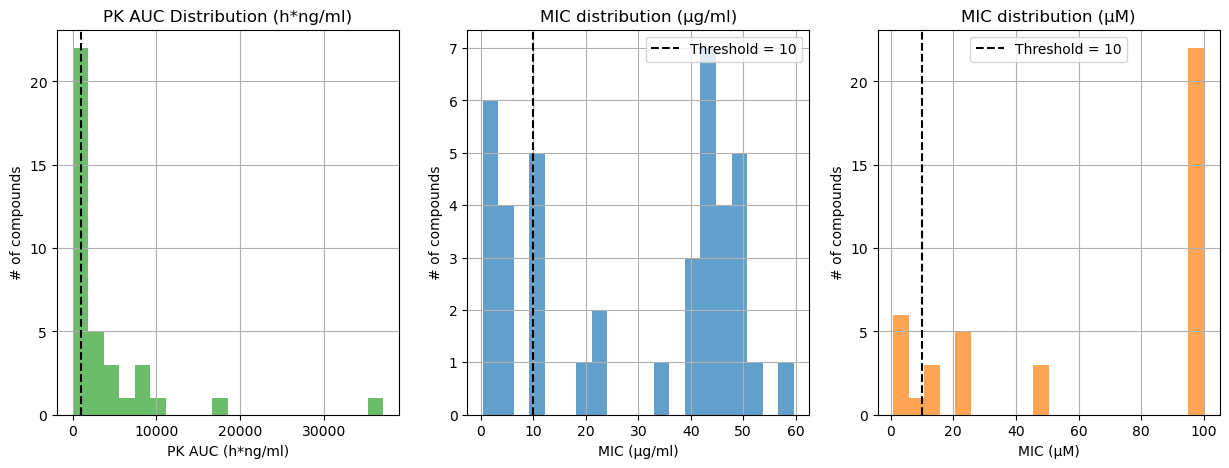

In [117]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df_res['snapshot_pk_auc_(h*ng/ml)'].hist(bins=20, ax=ax[0], color='tab:green', alpha=0.7)
ax[0].axvline(x=1000, label='Threshold = 1000', linestyle='dashed', color='black')
ax[0].set_xlabel('PK AUC (h*ng/ml)')
ax[0].set_ylabel('# of compounds')
ax[0].set_title('PK AUC Distribution (h*ng/ml)')

df_res['min_mic_(µg/ml)'].hist(bins=20, ax=ax[1], alpha=0.7)
df_res['min_mic_(µm)'].hist(bins=20, ax=ax[2], color='tab:orange', alpha=0.7)

ax[1].set_title('MIC distribution (µg/ml)')
ax[2].set_title('MIC distribution (µM)')

ax[1].set_xlabel('MIC (µg/ml)')
ax[2].set_xlabel('MIC (µM)')

ax[1].set_ylabel('# of compounds')
ax[2].set_ylabel('# of compounds')

ax[1].axvline(x=10.0, linestyle='dashed', color='black', label='Threshold = 10')
ax[2].axvline(x=10.0, linestyle='dashed', color='black', label='Threshold = 10')

ax[1].legend()
ax[2].legend()

plt.show()

In [81]:
merged_lab_df = pd.merge(df_res, df_select_add, left_on='enamine_id', right_on='Molecule Id', how='left')
merged_lab_df.sort_values('snapshot_pk_auc_(h*ng/ml)', axis=0, inplace=True, ascending=False)

See where the sampled molecules lie in terms of their PK and Overall Negative Cumulative Rank

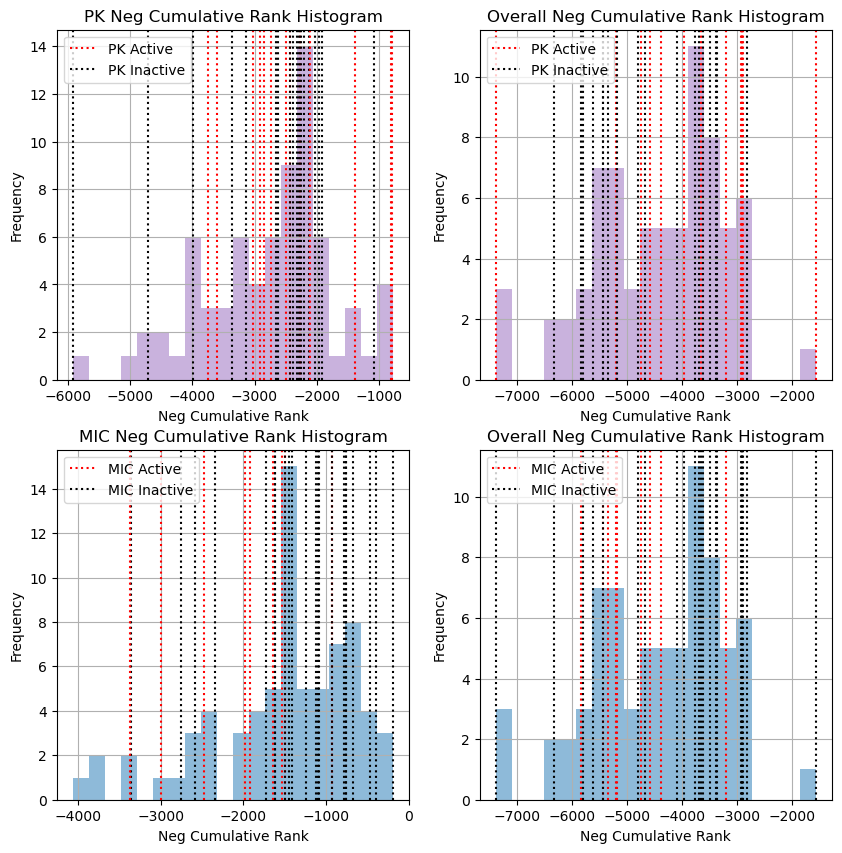

In [96]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0][0].set_title('PK Neg Cumulative Rank Histogram')
ax[0][1].set_title('Overall Neg Cumulative Rank Histogram')

ax[1][0].set_title('MIC Neg Cumulative Rank Histogram')
ax[1][1].set_title('Overall Neg Cumulative Rank Histogram')

for i in [0, 1]:
    for j in [0, 1]:
        ax[i][j].set_xlabel('Neg Cumulative Rank')
        ax[i][j].set_ylabel('Frequency')

df_select_add['pk_neg_cumulative_rank'].hist(bins=20, ax=ax[0][0], alpha=0.5, color='tab:purple')
df_select_add['neg_cumulative_rank'].hist(bins=20, ax=ax[0][1], alpha=0.5, color='tab:purple')

df_select_add['mic_neg_cumulative_rank'].hist(bins=20, ax=ax[1][0], alpha=0.5, color='tab:blue')
df_select_add['neg_cumulative_rank'].hist(bins=20, ax=ax[1][1], alpha=0.5, color='tab:blue')

for mic_ncr, pk_ncr, ncr, pk_active, mic_active in \
    merged_lab_df[['mic_neg_cumulative_rank', 'pk_neg_cumulative_rank', 'neg_cumulative_rank', 'pk_active', f'mic_active_{MIC_PRED_MODE}']].values:
    if pd.notnull(pk_ncr) and pd.notnull(mic_ncr):
        c_pk = 'red' if pk_active else 'black'
        c_mic = 'red' if mic_active else 'black'
        
        ax[0][0].axvline(x=pk_ncr, linestyle='dotted', color=c_pk)
        ax[0][1].axvline(x=ncr, linestyle='dotted', color=c_pk)
        
        ax[1][0].axvline(x=mic_ncr, linestyle='dotted', color=c_mic)
        ax[1][1].axvline(x=ncr, linestyle='dotted', color=c_mic)
    
red_line_pk = mlines.Line2D([], [], color='red', linestyle='dotted', markersize=15, label='PK Active')
black_line_pk = mlines.Line2D([], [], color='black', linestyle='dotted', markersize=15, label='PK Inactive')

red_line_mic = mlines.Line2D([], [], color='red', linestyle='dotted', markersize=15, label='MIC Active')
black_line_mic = mlines.Line2D([], [], color='black', linestyle='dotted', markersize=15, label='MIC Inactive')

ax[0][0].legend(handles=[red_line_pk, black_line_pk])
ax[0][1].legend(handles=[red_line_pk, black_line_pk])
ax[1][0].legend(handles=[red_line_mic, black_line_mic])
ax[1][1].legend(handles=[red_line_mic, black_line_mic])

plt.show()

Scatterplot of PK AUC vs Rank

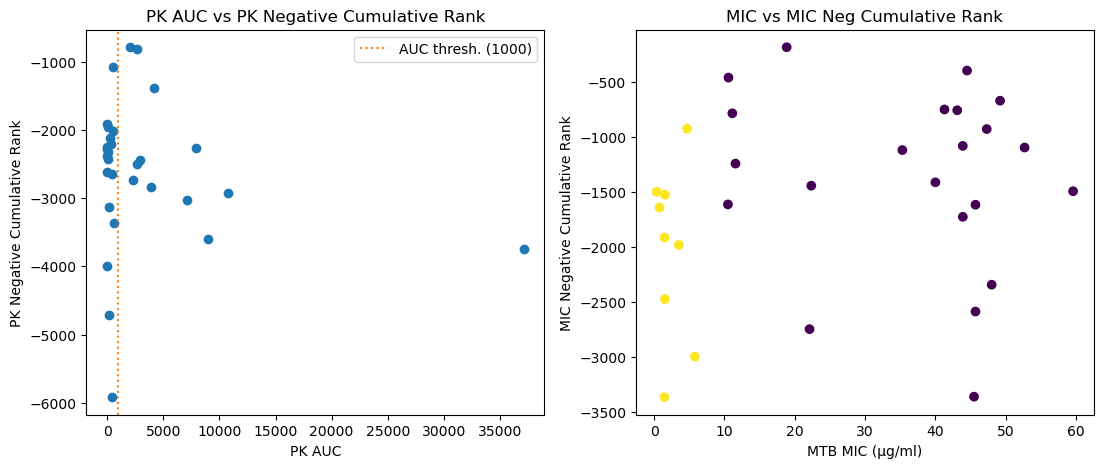

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax[0].scatter(x=merged_lab_df['snapshot_pk_auc_(h*ng/ml)'].values, 
              y=merged_lab_df['pk_neg_cumulative_rank'].values)
ax[0].set_title('PK AUC vs PK Negative Cumulative Rank')
ax[0].set_xlabel('PK AUC')
ax[0].set_ylabel('PK Negative Cumulative Rank')
ax[0].axvline(x=1000, linestyle='dotted', color='tab:orange', label='AUC thresh. (1000)')
ax[0].legend()

ax[1].scatter(x=merged_lab_df[f'min_mic_({MIC_UNIT_PLTS})'].values, 
              y=merged_lab_df['mic_neg_cumulative_rank'].values,
              c=merged_lab_df[f'mic_active_{MIC_PRED_MODE}'].astype(int).values)
ax[1].set_title('MIC vs MIC Neg Cumulative Rank')
ax[1].set_xlabel(f'MTB MIC ({MIC_UNIT_PLTS})')
ax[1].set_ylabel('MIC Negative Cumulative Rank')
plt.show()

In [98]:
merged_lab_df[['snapshot_pk_auc_(h*ng/ml)'] + pk_rank_cols].corr(numeric_only=True).loc['snapshot_pk_auc_(h*ng/ml)']

snapshot_pk_auc_(h*ng/ml)                       1.000000
Khadija PK LightGBM Model Rank                  0.335008
Khadija PK XGBoost Model Rank                   0.233478
Chemprop PK Rank                               -0.133550
RandomForestClassifier/optuna/P2 Rank           0.370857
RandomForestClassifier/random_search/P2 Rank    0.268854
RandomForestClassifier/hyperopt/P2 Rank         0.297005
CatBoostClassifier/random_search/P2 Rank       -0.269452
Khadija PK RF Model Rank                       -0.145058
Name: snapshot_pk_auc_(h*ng/ml), dtype: float64

In [99]:
merged_lab_df[[f'min_mic_({MIC_UNIT_PLTS})'] + mic_rank_cols].corr(numeric_only=True).loc[f'min_mic_({MIC_UNIT_PLTS})']

min_mic_(µg/ml)                     1.000000
TAACF MIC Classic RF F1 Rank       -0.254378
TAACF MIC Class Weight F1 Rank     -0.096398
TAACF MIC chemprop Rank            -0.109416
MLSMR chemprop Model Rank           0.012515
MLSMR Class Weight F1 Model Rank   -0.204414
UnderSampling F1 Model Rank        -0.156721
MLSMR BootStrap F1 Model Rank      -0.150104
Name: min_mic_(µg/ml), dtype: float64

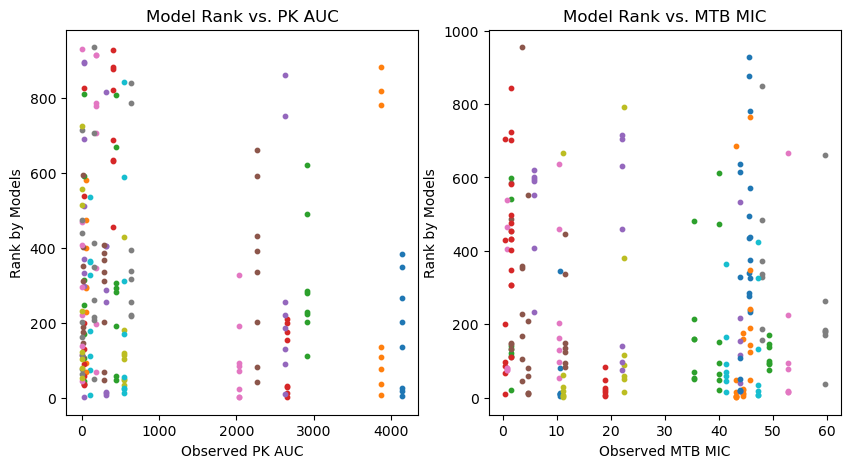

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for row in merged_lab_df[['snapshot_pk_auc_(h*ng/ml)'] + pk_rank_cols].values:
    if row[0] < 5000:
        n_models = len(row)-1
        ax[0].scatter([row[0]]*n_models, row[1:], s=10)
        
for row in merged_lab_df[[f'min_mic_({MIC_UNIT_PLTS})'] + mic_rank_cols].values:
    n_models = len(row)-1
    ax[1].scatter([row[0]]*n_models, row[1:], s=10)
        
ax[0].set_xlabel('Observed PK AUC')
ax[0].set_ylabel('Rank by Models')
ax[0].set_title('Model Rank vs. PK AUC')

ax[1].set_xlabel('Observed MTB MIC')
ax[1].set_ylabel('Rank by Models')
ax[1].set_title('Model Rank vs. MTB MIC')

plt.show()

In [31]:
# df.to_csv('../data/master_sheet_apr30.csv')
# df_select_add.to_csv('../data/selected_mols_apr30.csv')

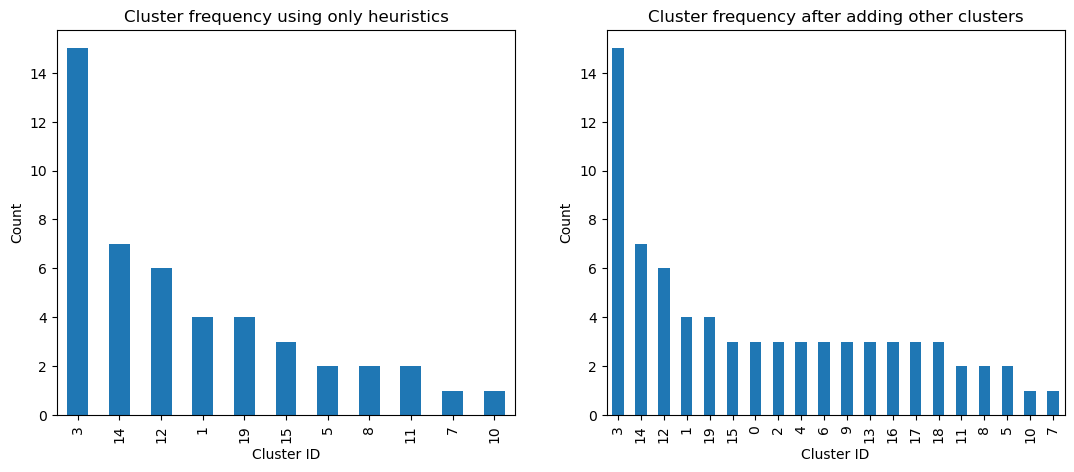

In [20]:
# fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# df_select['Cluster'].value_counts().plot(ax=axes[0], kind='bar')
# df_select_add['Cluster'].value_counts().plot(ax=axes[1], kind='bar')

# axes[0].set_title('Cluster frequency using only heuristics')
# axes[0].set_xlabel('Cluster ID')
# axes[0].set_ylabel('Count')

# axes[1].set_title('Cluster frequency after adding other clusters')
# axes[1].set_xlabel('Cluster ID')
# axes[1].set_ylabel('Count')

# plt.show()